# Задача №7: Построить модель машинного обучения

## Постановка задачи

В этой же папке на диске лежит файл dataset.csv

Ваша задача провести анализ данных, построить и оценить модель классификации. Выбор метрик и моделей за вами. Решение должно быть загружено в формате .ipynb или .html

Оценка работ будет производиться по следующим критериям:

- Качественный EDA
- Корректные и обоснованные трансформации данных
- Корректное и обоснованное обучение и оценка модели
- Качество кода и чистота jupyter notebook


Описание данных

Это набор данных HR. Задача состоит в том, чтобы проверить, получил ли сотрудник повышение или нет.
Названия колонок:
	•	employee_id
	•	department
	•	region
	•	education
	•	gender
	•	recruitment_channel
	•	nooftrainings
	•	age
	•	previousyearrating
	•	lengthofservice
	•	KPIs_met >80%
	•	awards_won?
	•	avgtrainingscore
	•	is_promoted

Если по названию колонки все еще не понятно, что в ней содержится, мы ожидаем, что вы сделаете свои предположения на основе анализа данных.

## Загрузка данных

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [29]:
df = pd.read_csv("dataset.csv")
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


## EDA

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [31]:
# посмотрим в каких признаках есть пропуски
df.isna().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [32]:
# общее кол-во записей с пропусками в признаках
isna_number = df[
    (df['education'].isna() == True) | (df['previous_year_rating'].isna() == True)
]["employee_id"].count()
print(f"Всего записей с пропусками = {isna_number}, общее кол-во записей в датасете = {df.shape[0]}")
print(f"Доля пропусков в датасете = {round(isna_number / df.shape[0], 1)}%")

Всего записей с пропусками = 6148, общее кол-во записей в датасете = 54808
Доля пропусков в датасете = 0.1%


In [33]:
# посмотрим есть ли полные дубликаты
df.duplicated().sum()

0

In [34]:
df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [35]:
df.describe(include="object")

,department,region,education,gender,recruitment_channel
count,54808,54808,52399,54808,54808
unique,9,34,3,2,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,16840,12343,36669,38496,30446


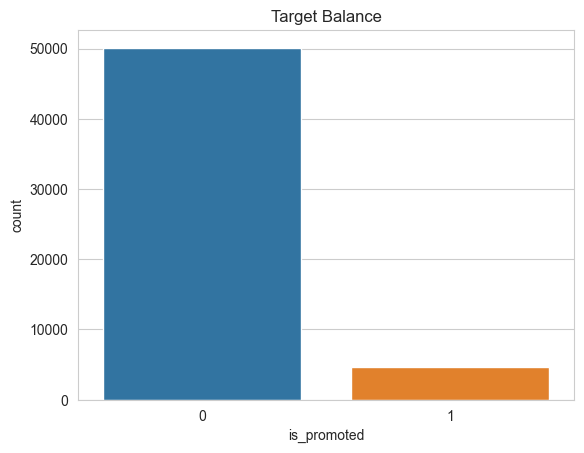

0    0.91483
1    0.08517
Name: is_promoted, dtype: float64

In [36]:
# Проверим сбалансированна ли целевая переменная
sns.countplot(x='is_promoted', data=df)
plt.title('Target Balance')
plt.show()

# Рассчитаем долю каждого класса
df['is_promoted'].value_counts(normalize=True)

Видим значительный дисбаланс классов.

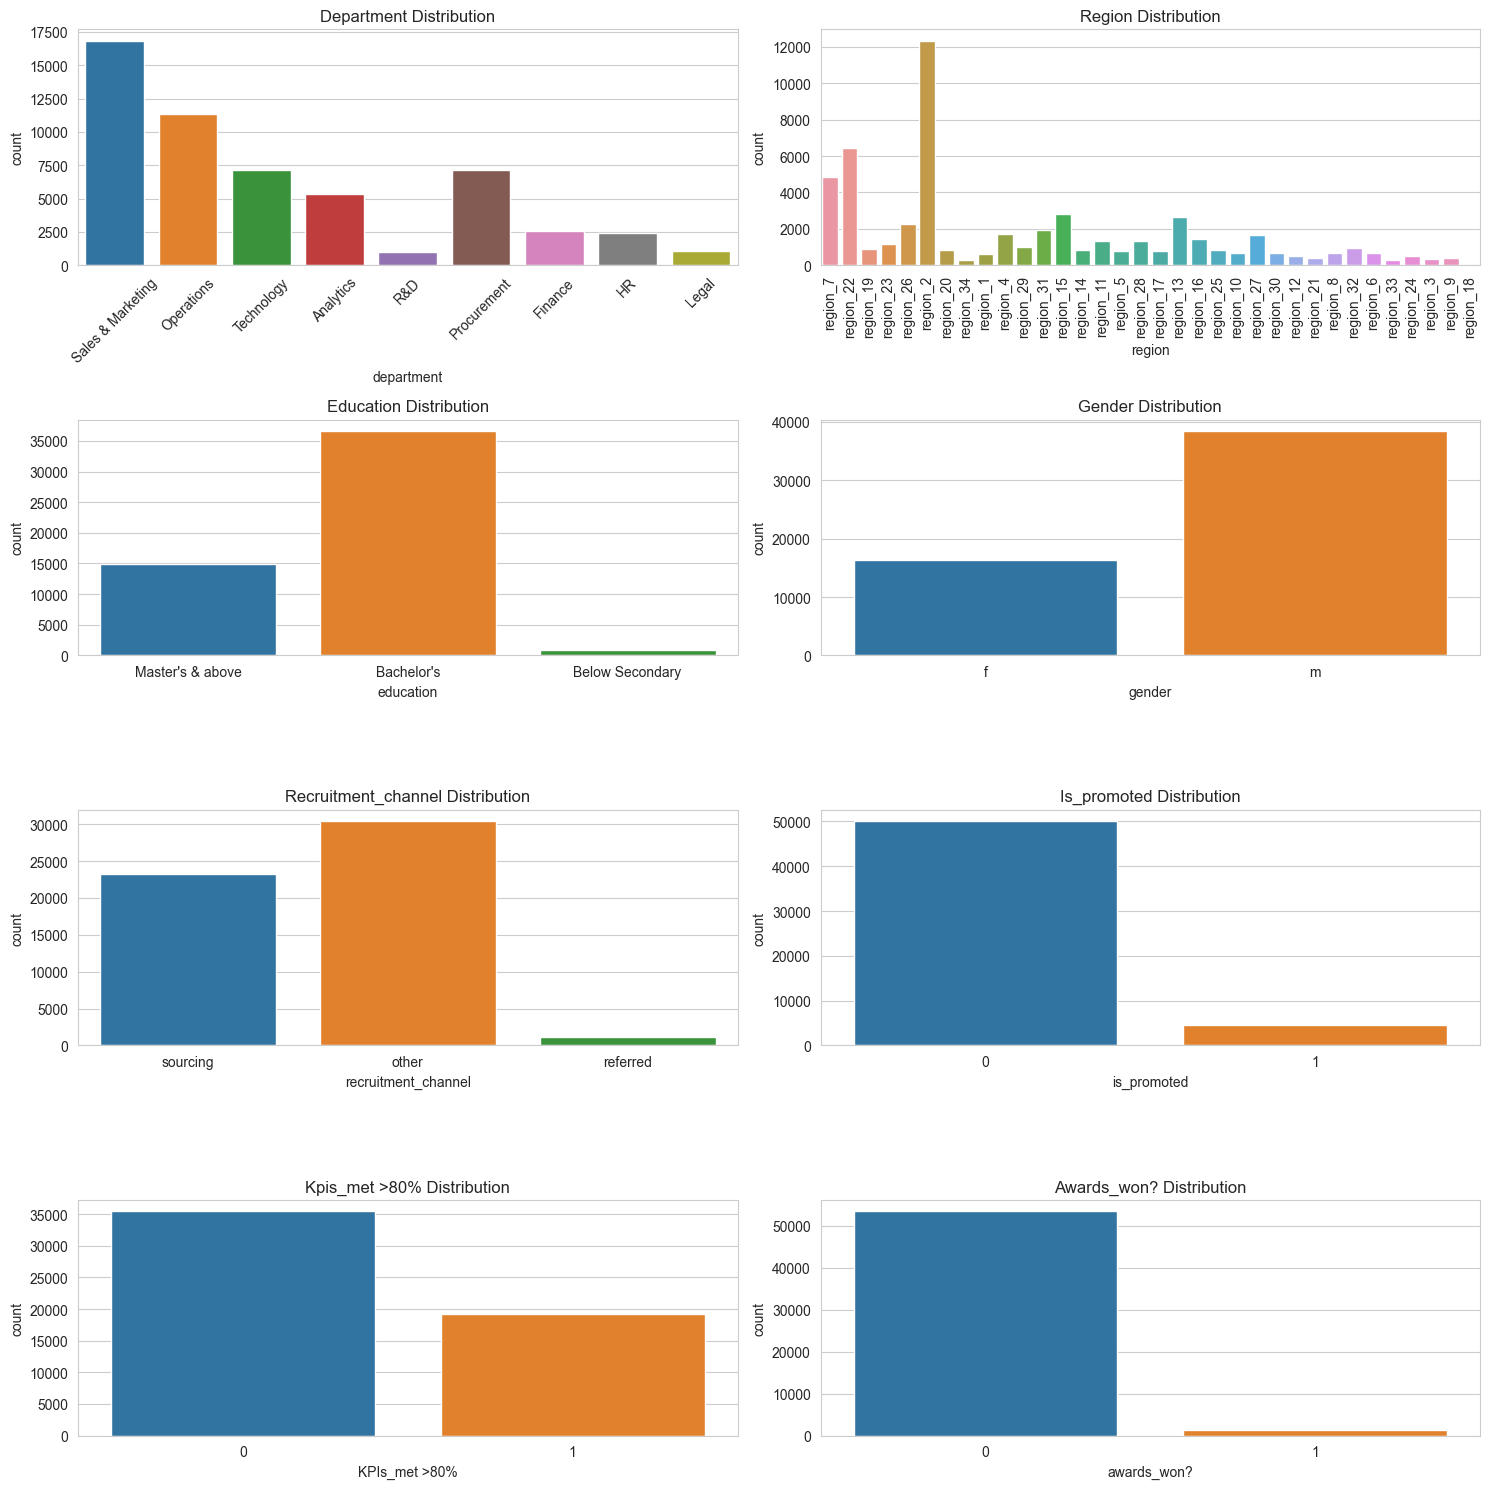

In [37]:
# Построим графики для категориальных признаков
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

columns = ['department', 'region', 'education', 'gender',
           'recruitment_channel', 'is_promoted', 'KPIs_met >80%', 'awards_won?']
rotations = [45, 90, 0, 0, 0, 0, 0, 0]

for ax, col, rot in zip(axes.flatten(), columns, rotations):
    sns.countplot(x=col, data=df, ax=ax)
    ax.set_title(f'{col.capitalize()} Distribution')
    ax.tick_params(axis='x', rotation=rot)

plt.tight_layout()
plt.show()

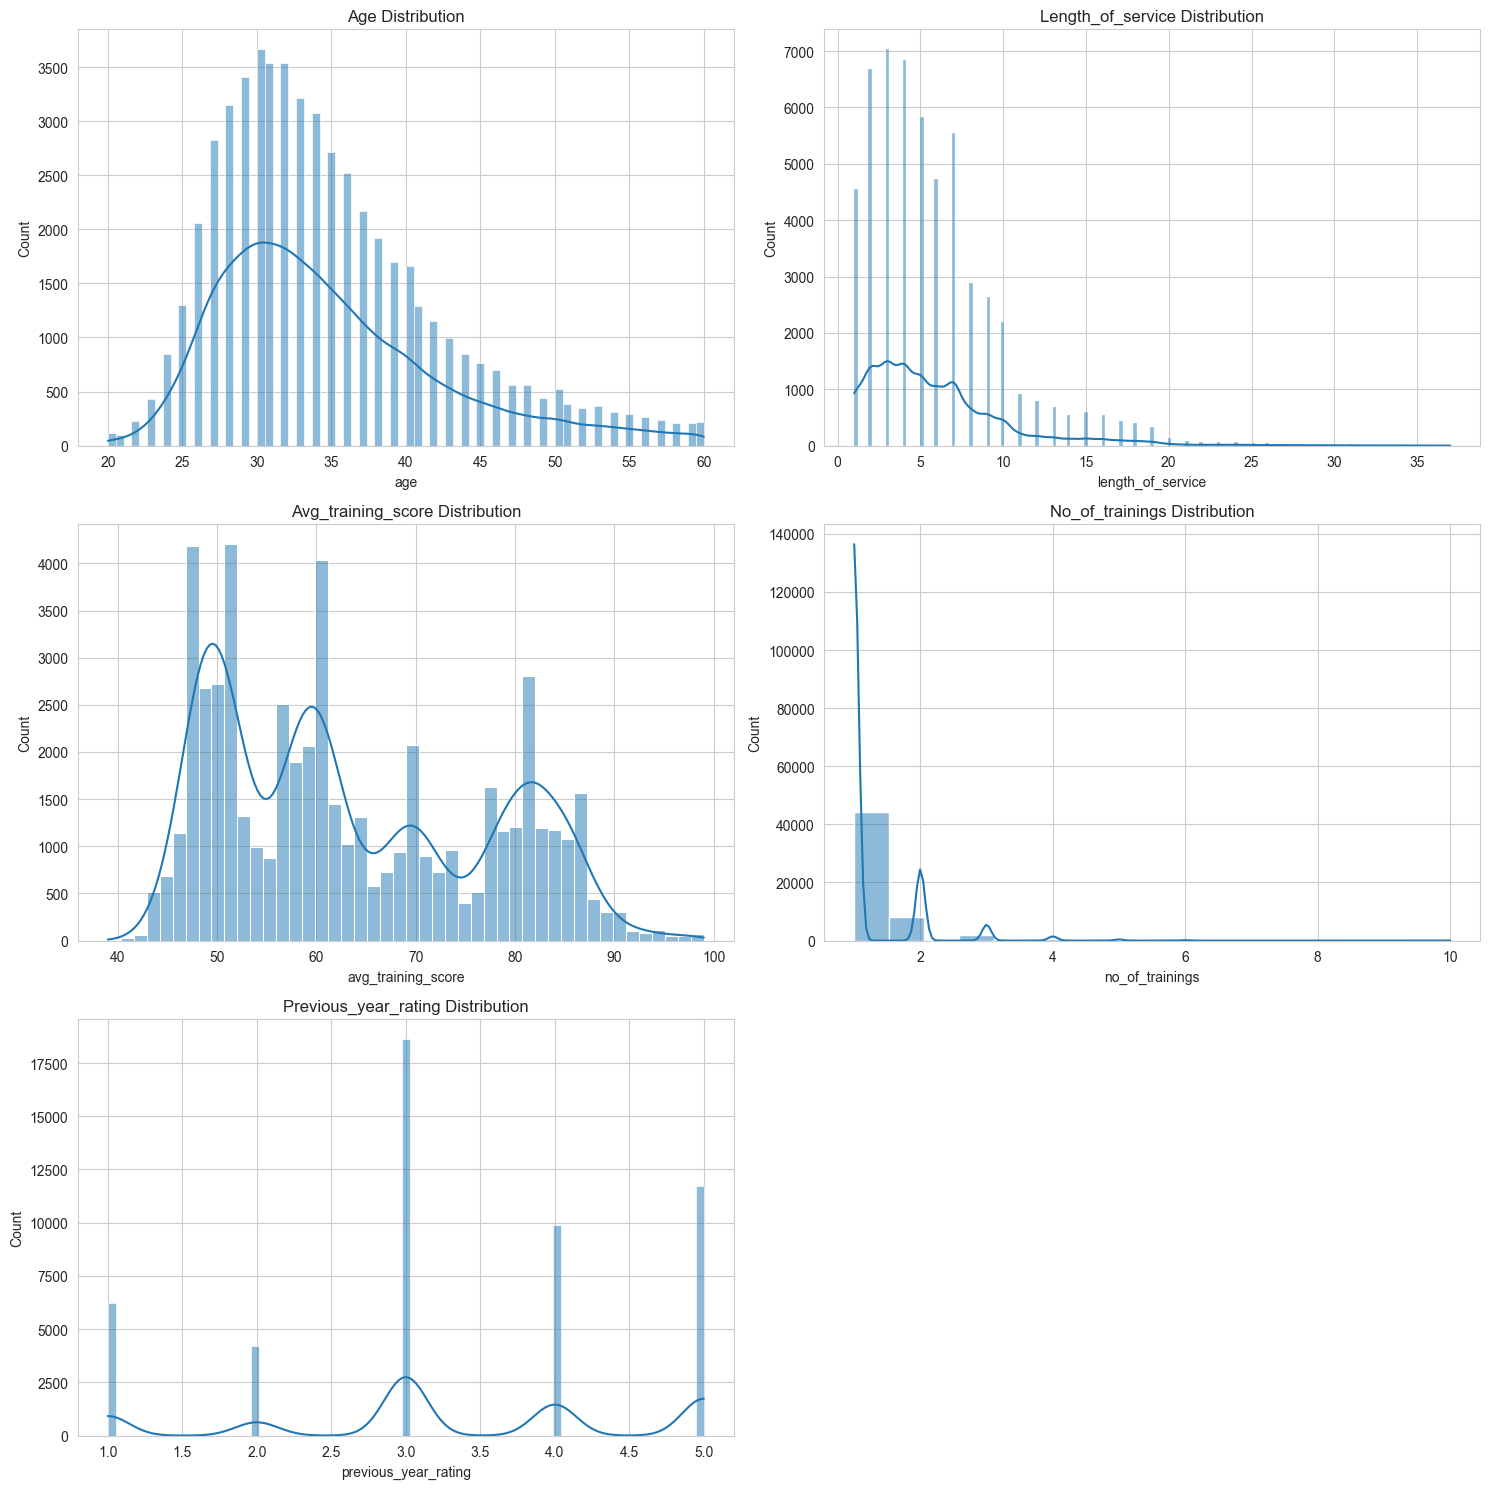

In [38]:
# Построим графики для числовых признаков
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

columns = ['age', 'length_of_service', 'avg_training_score',
           'no_of_trainings', 'previous_year_rating']

for ax, col in zip(axes.flatten(), columns):
    sns.histplot(x=col, data=df, kde=True, ax=ax)
    ax.set_title(f'{col.capitalize()} Distribution')
    ax.tick_params(axis='x', rotation=rot)

if len(columns) < len(axes.flatten()):
    axes.flatten()[len(columns)].set_visible(False)

plt.tight_layout()
plt.show()

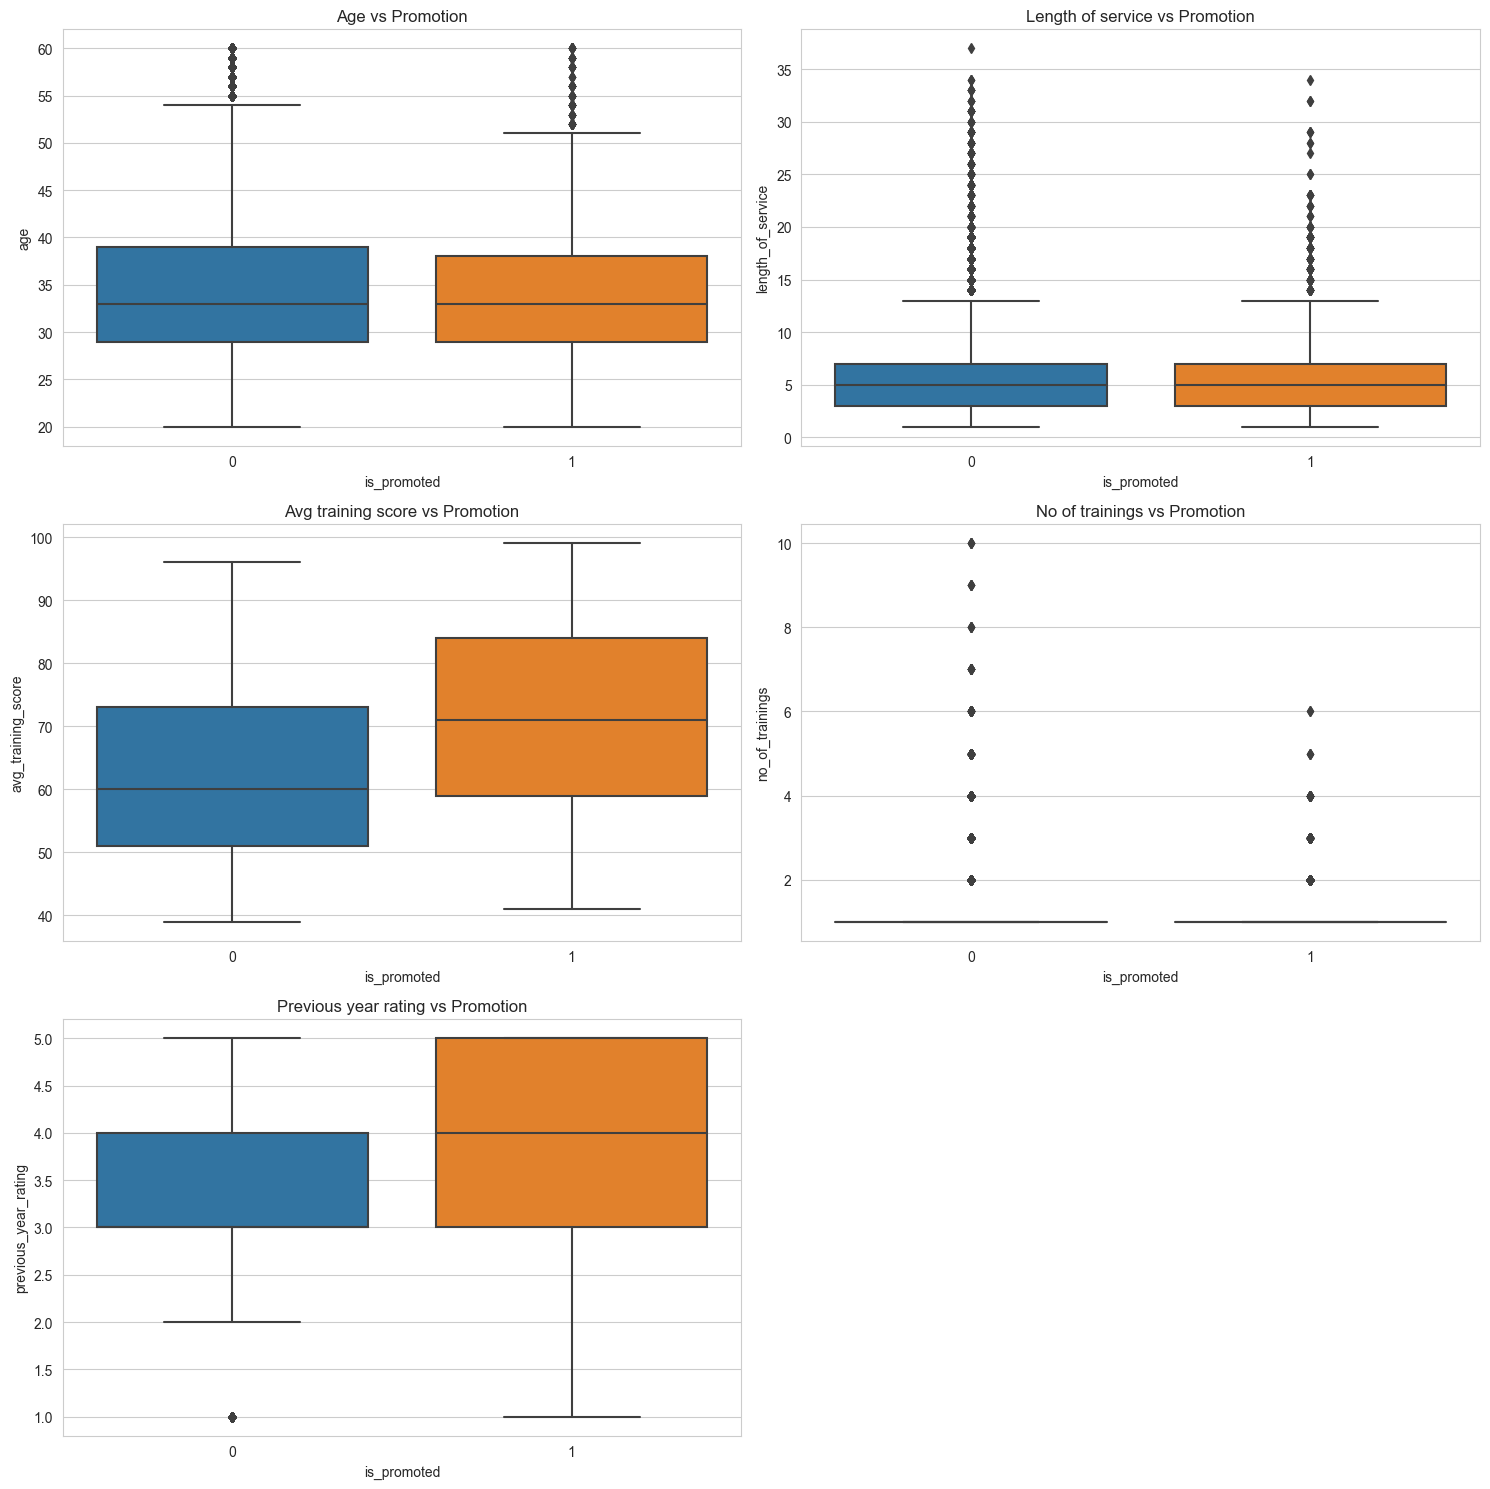

In [39]:
# Посмотрим на взаимосвязь между таргетом и числовыми признаками
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

features = ['age', 'length_of_service', 'avg_training_score', 'no_of_trainings', 'previous_year_rating']
titles = [f'{feature.replace("_", " ").capitalize()} vs Promotion' for feature in features]

for ax, feature, title in zip(axes.flatten(), features, titles):
    sns.boxplot(x='is_promoted', y=feature, data=df, ax=ax)
    ax.set_title(title)

if len(features) < len(axes.flatten()):
    axes.flatten()[len(features)].set_visible(False)

plt.tight_layout()
plt.show()

Следующие признаки оказывают значительное влияние на повышение по службе:

**'avg_training_score'**: Более высокие результаты обучения связаны с более высокой вероятностью продвижения по службе.
**'previous_year_rating'**: сотрудники с более высоким рейтингом в прошлом году имеют больше шансов получить повышение по службе.

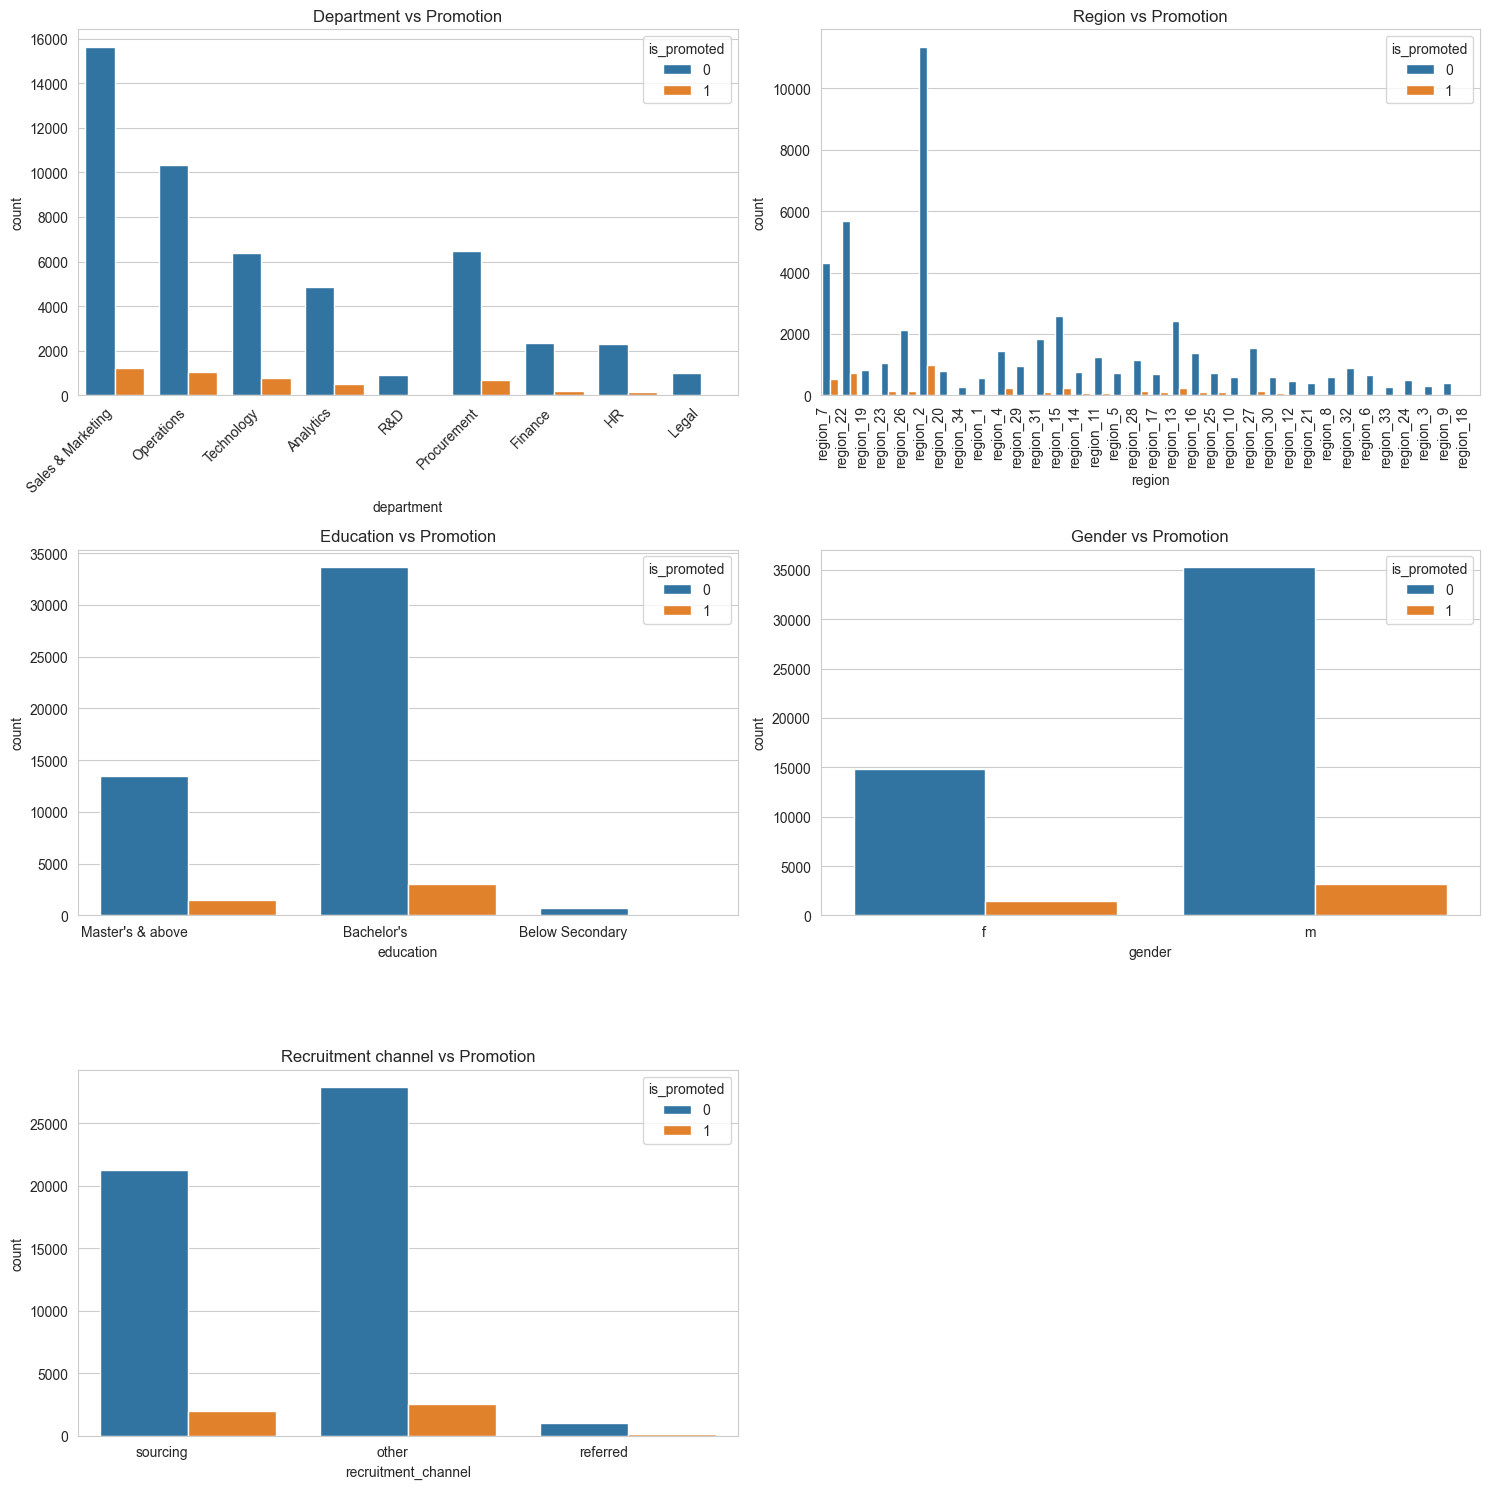

In [40]:
# Посмотрим на взаимосвязь между таргетом и категориальными признаками
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

features = ['department', 'region', 'education', 'gender', 'recruitment_channel']
rotations = [45, 90, 0, 0, 0]

for ax, feature, rotation in zip(axes.flatten(), features, rotations):
    sns.countplot(x=feature, hue='is_promoted', data=df, ax=ax)
    ax.set_title(f'{feature.replace("_", " ").capitalize()} vs Promotion')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right')

# Hide the last subplot if it's not used
if len(features) < len(axes.flatten()):
    axes.flatten()[len(features)].axis('off')

plt.tight_layout()
plt.show()

## Трансформация данных

In [41]:
# Заполним недостающие значения в 'education' наиболее частым значением
imputer = SimpleImputer(strategy='most_frequent')
df['education'] = imputer.fit_transform(df[['education']])

# Заполним недостающие значения в 'previous_year_rating' средним значением
imputer = SimpleImputer(strategy='mean')
df['previous_year_rating'] = imputer.fit_transform(df[['previous_year_rating']])

In [42]:
# Использование каждого из этих признаков ухудшает результат предсказания модели, поэтому не используем в финале

# # создадим новые признаки
# df['total_training_rating_score'] = df['avg_training_score'] + df['previous_year_rating']
# df['total_training_rating_score_to_age'] = (df['avg_training_score'] + df['previous_year_rating']) / df['age']
# df['avg_training_score_per_training'] = df['avg_training_score'] / df['no_of_trainings']
#
# top_regions = ['region_2', 'region_7', 'region_22']
# df['region_division'] = df['region'].apply(lambda x: 'top_regions' if x in top_regions else 'other_regions')

## Обучение и оценка модели

**Выбор модели и обучение:**
Для этой задачи мы будем использовать следующие модели классификации:
- RandomForestClassifier
- CatBoostClassifier

**Выбор метрик:**
Учитывая, что у нас дисбаланс классов, для оценки результата предсказания данной задачи классификации мы будем использовать:
- Precision-Recall AUC (особенно полезна при работе с несбалансированными классами)
- ROC AUC
- F1-мера
- Accuracy (мало полезна при дисбалансе)

### Подготовка данных для использования в моделях

In [43]:
# Разобъем данные на признаки и таргет.
# Избавимся от неинформативного признака 'employee_id'
X = df.drop(columns=['employee_id', 'is_promoted'])
y = df['is_promoted']

# Разобъем датасет на обучающий и тестовый (валидационный не будем выделять в данном случае)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = X.select_dtypes(include='number').columns
categorical_features = X.select_dtypes(exclude='number').columns

In [44]:
# Масштабируем числовые признаки
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Закодируем категориальные признаки
le = LabelEncoder()
for column in categorical_features:
    X_train[column] = le.fit_transform(X_train[column])
    X_test[column] = le.transform(X_test[column])

# Используем SMOTE на обучающей выборке, чтобы избавиться от дисбаланса классов
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

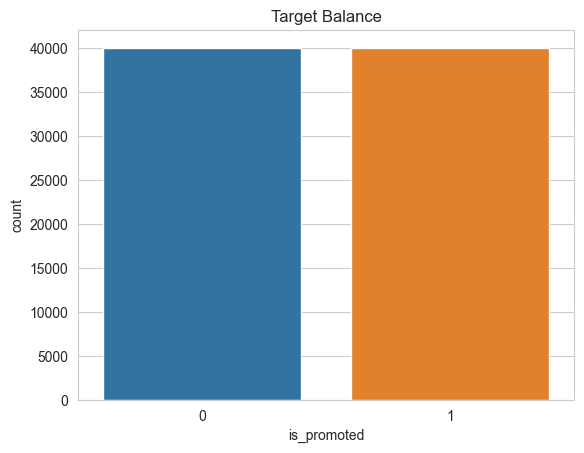

0    0.5
1    0.5
Name: is_promoted, dtype: float64

In [45]:
# Проверим сбалансированна ли теперь целевая переменная в обучающей выборке
sns.countplot(x=y_train_smote)
plt.title('Target Balance')
plt.show()

# Рассчитаем долю каждого класса
y_train_smote.value_counts(normalize=True)

In [46]:
# Целевая переменная в тестовой выборке осталась как есть
y_test.value_counts()

0    10054
1      908
Name: is_promoted, dtype: int64

### RandomForestClassifier

In [47]:
# Обучим RandomForestClassifier на сбалансированной обучающей выборке
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [48]:
# Сделаем предсказание на тестовой выборке
y_pred_rf_best = rf.predict(X_test)
y_proba_rf_best = rf.predict_proba(X_test)[:, 1]

In [49]:
# Посчитаем метрики
accuracy_rf_best = accuracy_score(y_test, y_pred_rf_best)
roc_auc_rf_best = roc_auc_score(y_test, y_proba_rf_best)
conf_matrix_rf_best = confusion_matrix(y_test, y_pred_rf_best)
precision, recall, _ = precision_recall_curve(y_test, y_proba_rf_best)
pr_auc_rf_best = auc(recall, precision)
f1_rf_best = f1_score(y_test, y_pred_rf_best)

print(f"Random Forest Accuracy: {accuracy_rf_best}")
print(f"Random Forest ROC AUC Score: {roc_auc_rf_best}")
print(f"Random Forest Precision-Recall AUC Score: {pr_auc_rf_best}")
print(f"Random Forest F1 Score: {f1_rf_best}")

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_best))

Random Forest Accuracy: 0.9212734902390075
Random Forest ROC AUC Score: 0.8784996043392114
Random Forest Precision-Recall AUC Score: 0.4842079730801234
Random Forest F1 Score: 0.4370515329419439
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     10054
           1       0.54      0.37      0.44       908

    accuracy                           0.92     10962
   macro avg       0.74      0.67      0.70     10962
weighted avg       0.91      0.92      0.91     10962



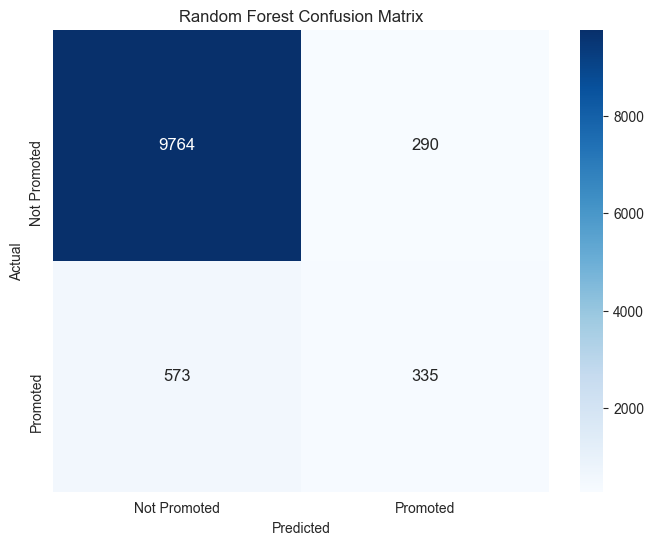

In [50]:
# Построим график confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Promoted', 'Promoted'], yticklabels=['Not Promoted', 'Promoted'],
            annot_kws={"fontsize": 12})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Random Forest Confusion Matrix')
plt.show()

RandomForestClassifier на тестовых данных предсказывает, что:
- не получат продвижения 9764 (из 10054 реально не получивших)
- получат продвижение 335 (из 908 реально получивших)

Модель ошибочно предсказывает, что 573 не получат продвижения (из 908 реально получивших). Видимо, что на положительном классе модель RandomForestClassifier значительно ошибается.

### CatBoostClassifier

In [51]:
# Обучим CatBoostClassifier на сбалансированной обучающей выборке
catboost_model = CatBoostClassifier(verbose=100, random_state=42)
catboost_model.fit(X_train_smote, y_train_smote, eval_set=(X_test, y_test), early_stopping_rounds=50)

# Сделаем предсказание на тестовой выборке
y_pred_catboost_best = catboost_model.predict(X_test)
y_proba_catboost_best = catboost_model.predict_proba(X_test)[:, 1]

# Посчитаем метрики
accuracy_catboost_best = accuracy_score(y_test, y_pred_catboost_best)
roc_auc_catboost_best = roc_auc_score(y_test, y_proba_catboost_best)
conf_matrix_catboost_best = confusion_matrix(y_test, y_pred_catboost_best)
precision_catboost, recall_catboost, _ = precision_recall_curve(y_test, y_proba_catboost_best)
pr_auc_catboost_best = auc(recall_catboost, precision_catboost)
f1_catboost_best = f1_score(y_test, y_pred_catboost_best)

print(f"CatBoost Accuracy: {accuracy_catboost_best}")
print(f"CatBoost ROC AUC Score: {roc_auc_catboost_best}")
print(f"CatBoost Precision-Recall AUC Score: {pr_auc_catboost_best}")
print(f"CatBoost Forest F1 Score: {f1_catboost_best}")

print("Optimized CatBoost Classification Report:")
print(classification_report(y_test, y_pred_catboost_best))

Learning rate set to 0.093584
0:	learn: 0.6265822	test: 0.6356201	best: 0.6356201 (0)	total: 13.5ms	remaining: 13.5s
100:	learn: 0.1442837	test: 0.1975173	best: 0.1975173 (100)	total: 767ms	remaining: 6.83s
200:	learn: 0.1099312	test: 0.1745639	best: 0.1745639 (200)	total: 1.43s	remaining: 5.69s
300:	learn: 0.0988976	test: 0.1697045	best: 0.1697045 (300)	total: 2.09s	remaining: 4.86s
400:	learn: 0.0917083	test: 0.1674855	best: 0.1673694 (386)	total: 2.86s	remaining: 4.28s
500:	learn: 0.0867334	test: 0.1669457	best: 0.1669179 (482)	total: 3.51s	remaining: 3.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1669179352
bestIteration = 482

Shrink model to first 483 iterations.
CatBoost Accuracy: 0.9428024083196497
CatBoost ROC AUC Score: 0.9051096545614037
CatBoost Precision-Recall AUC Score: 0.5916879563471809
CatBoost Forest F1 Score: 0.500398406374502
Optimized CatBoost Classification Report:
              precision    recall  f1-score   support

           0      

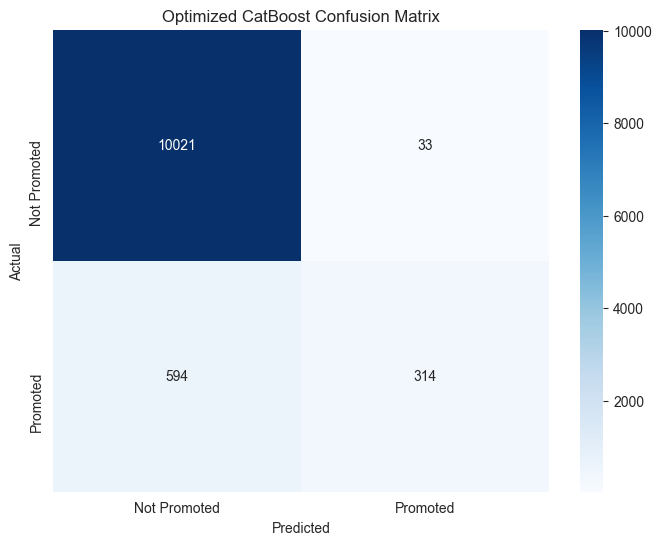

In [52]:
# Построим график confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_catboost_best, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Promoted', 'Promoted'], yticklabels=['Not Promoted', 'Promoted'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Optimized CatBoost Confusion Matrix')
plt.show()

CatBoostClassifier на тестовых данных предсказывает, что:
- не получат продвижения 10021 (из 10054 реально не получивших)
- получат продвижение 314 (из 908 реально получивших)
Модель ошибочно предсказывает, что 594 не получат продвижения (из 908 реально получивших).

Видим, что на положительном классе модель CatBoostClassifier значительно ошибается, при этом практически 100% правильно предсказывает отрицательный класс.

In [53]:
# Сравним результаты метрик обеих моделей
print("Random Forest:")
print(f"Accuracy: {accuracy_rf_best}")
print(f"ROC AUC Score: {roc_auc_rf_best}")
print(f"Precision-Recall AUC Score: {pr_auc_rf_best}")
print(f"F1 Score: {f1_rf_best}")

print("\nCatBoost:")
print(f"Accuracy: {accuracy_catboost_best}")
print(f"ROC AUC Score: {roc_auc_catboost_best}")
print(f"Precision-Recall AUC Score: {pr_auc_catboost_best}")
print(f"F1 Score: {f1_catboost_best}")

Random Forest:
Accuracy: 0.9212734902390075
ROC AUC Score: 0.8784996043392114
Precision-Recall AUC Score: 0.4842079730801234
F1 Score: 0.4370515329419439

CatBoost:
Accuracy: 0.9428024083196497
ROC AUC Score: 0.9051096545614037
Precision-Recall AUC Score: 0.5916879563471809
F1 Score: 0.500398406374502


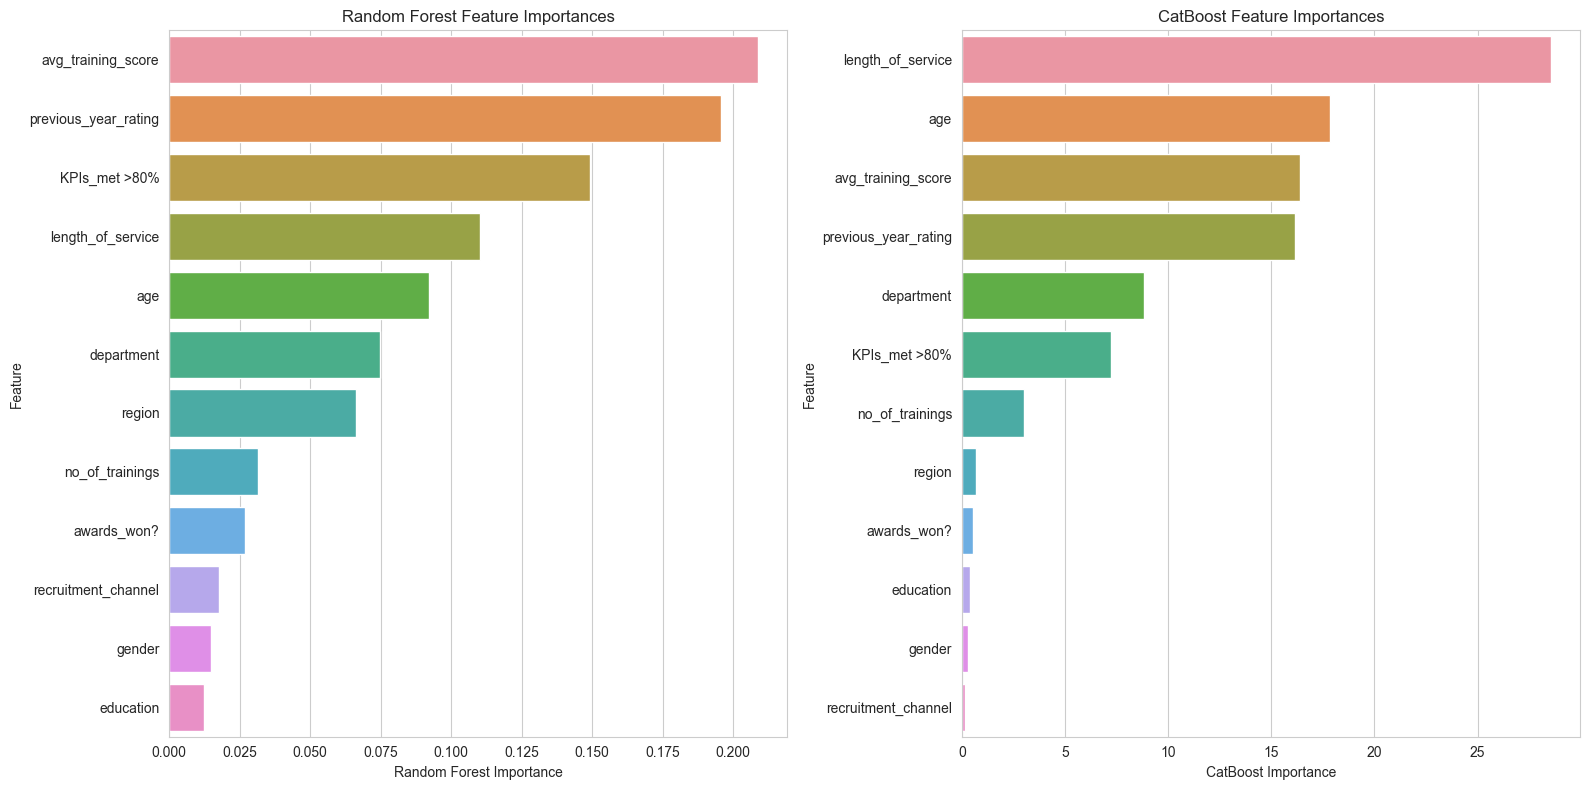

In [54]:
# Посмотрим на важность признаков для обеих моделей
rf_importances = rf.feature_importances_
catboost_importances = catboost_model.get_feature_importance()

features = X.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Random Forest Importance': rf_importances,
    'CatBoost Importance': catboost_importances
})

importance_df = importance_df.sort_values(by='Random Forest Importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(y='Feature', x='Random Forest Importance', data=importance_df, ax=axes[0])
axes[0].set_title('Random Forest Feature Importances')

importance_df = importance_df.sort_values(by='CatBoost Importance', ascending=False)
sns.barplot(y='Feature', x='CatBoost Importance', data=importance_df, ax=axes[1])
axes[1].set_title('CatBoost Feature Importances')

plt.tight_layout()
plt.show()

## Вывод

**Cравнение результатов двух моделей:**
- Accuracy: CatBoost (0,943) > RandomForest (0,921)
CatBoost имеет немного более высокую общую точность, что указывает на меньшее количество общих ошибок прогнозирования.
- ROC AUC: CatBoost (0,905) > RandomForest (0,878)
CatBoost имеет лучшую способность различать положительный и отрицательный классы.
- Precision-Recall AUC: CatBoost (0,592) > RandomForest (0,484)
CatBoost лучше прогнозирует положительный класс при сохранении высокой точности.
- F1: CatBoost (0,500) > RandomForest (0,437)
CatBoost имеет лучший баланс между точностью и полнотой.

**Заключение:**
Основываясь на этих показателях, CatBoost в целом превосходит RandomForest по всем оцениваемым метрикам.
Следовательно, считаем CatBoost лучшей моделью из рассмотренных для данной задачи классификации.
CatBoost обеспечивает более высокую точность, лучшую способность к распознаванию и лучший баланс между прогнозированием положительного класса и общим компромиссом между точностью и полнотой.